In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss

In [ ]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [2]:
# Hyperparameters
learning_rate = 0.001 # 0.096779
num_epochs = 240  # 200
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping


In [3]:
# # Load IdenProf dataset
# train_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/train'
# test_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/test'
# trainloader, testloader  = load_prof(train_path, test_path, batch_size=batch_size)

trainloader, testloader  = load_cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
# teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = torchvision.models.resnet18(weights=None).cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).to(device)
teacher_model.fc = nn.Linear(512, num_classes)
student_model = torchvision.models.resnet18(weights=None)
student_model.fc = nn.Linear(512, num_classes)


In [6]:
# # Instantiate the models
# ###################### Testing 2 ######################
# # Create instances of your models
# teacher_model = Teacher()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = Student()

In [7]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

100%|████████████████████████████████████████████████████████████████████████| 782/782 [05:27<00:00,  2.39it/s]


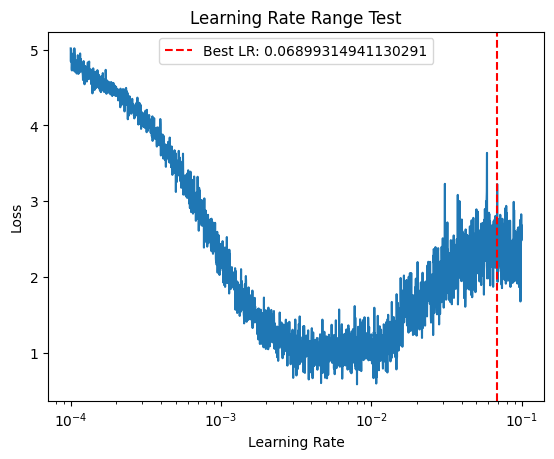

Best learning rate: 0.06899314941130291
0.06899314941130291


In [9]:
batch_size = 16  #to find the optimal learning rate
teacher_best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(teacher_best_lr)

100%|████████████████████████████████████████████████████████████████████████| 782/782 [03:52<00:00,  3.37it/s]


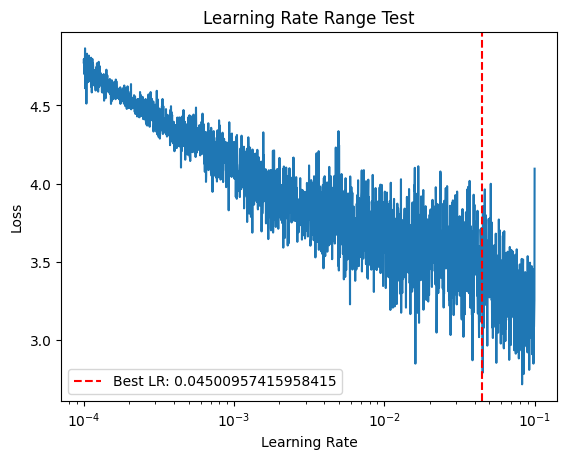

Best learning rate: 0.04500957415958415
0.04500957415958415


In [10]:
student_best_lr = train_teacher(student_model, trainloader, criterion, student_optimizer, student_scheduler, device, num_epochs=3)  
print(student_best_lr)

In [11]:
teacher_learning_rate = 0.06899314941130291
student_learning_rate = 0.04500957415958415


In [12]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=student_learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [13]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")


# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # from utils.loss_functions
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ckd_prof_checkpoint.pth')
            torch.save(student, f'student_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")

In [15]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


In [ ]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_cifar100.pth')
torch.save(student_model, 'student_model_ckd_cifar100.pth')
print('student weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_cifar100.pth')
torch.save(teacher_model, 'teacher_model_ckd_cifar100.pth')
print('teacher weights and architecture saved and exported')

In [15]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

{'accuracy': (0.90198, 0.35838), 'precision': (0.9076284382311101, 0.3526105056352366), 'recall': (0.90198, 0.35838), 'f1': (0.9011720993196152, 0.33791472796934985)}


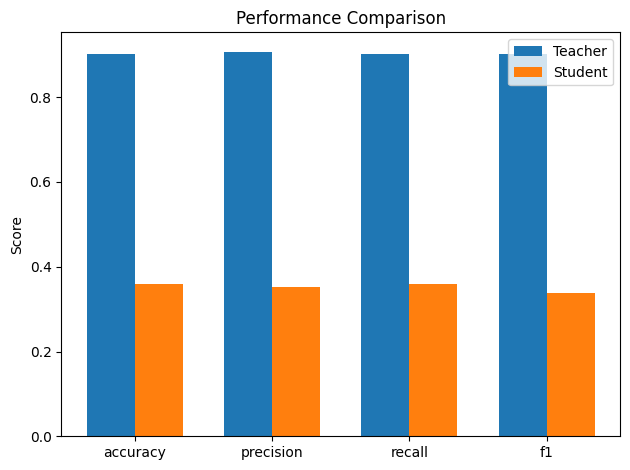

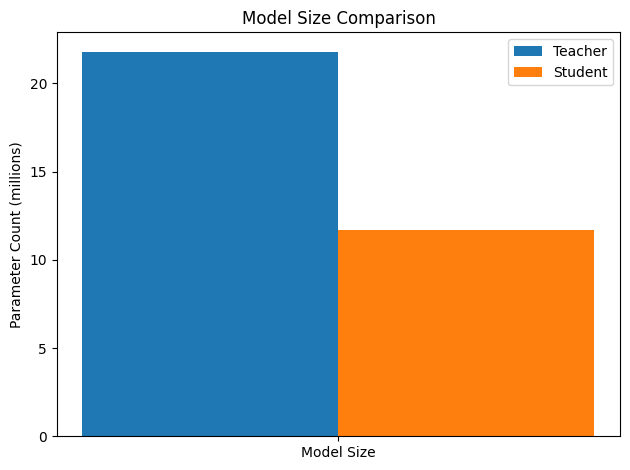

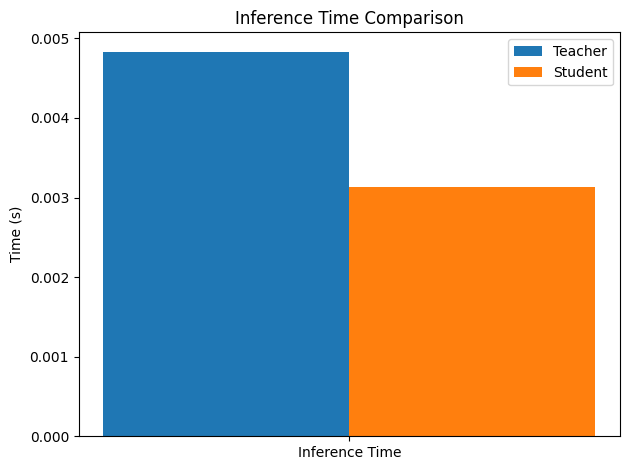

In [29]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

{'accuracy': (0.7208, 0.3393), 'precision': (0.7375023136238806, 0.3334531071527951), 'recall': (0.7208, 0.3393), 'f1': (0.719925399432651, 0.31939286155788893)}


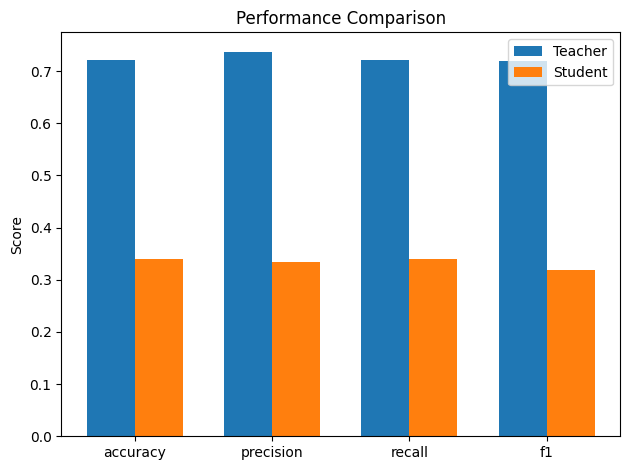

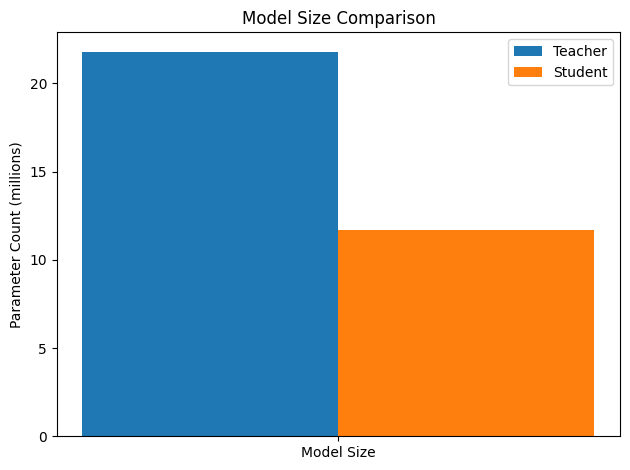

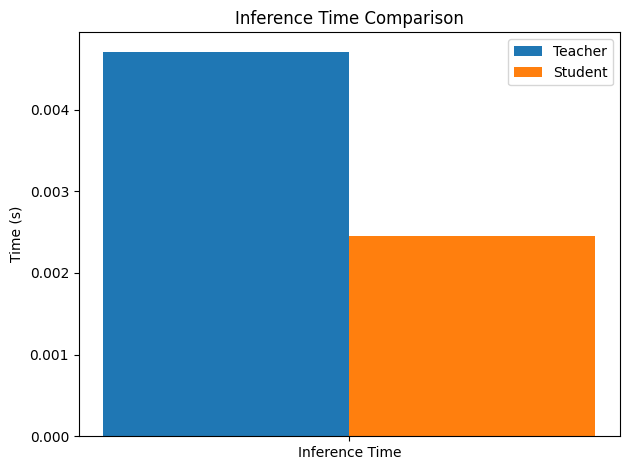

In [30]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')